<a href="https://colab.research.google.com/github/chindyfebryan/FlavourFinder/blob/main/model_with_MobileNet_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!kaggle datasets download -d very133/dataset-flavourfinder

In [ ]:
!unzip dataset-flavourfinder.zip

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "/content/dataset"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
def ingredient_model(image_shape=IMG_SIZE):
    base_model = tf.keras.applications.MobileNetV2(input_shape=image_shape + (3,),
                                                   include_top=False,
                                                   weights='imagenet')
    base_model.trainable = False

    inputs = tf.keras.Input(shape=image_shape + (3,))
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = tfl.BatchNormalization()(x)
    x = tfl.GlobalAveragePooling2D()(x)
    x = tfl.Dropout(0.2)(x)
    outputs = tfl.Dense(8, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [ ]:
base_model = ingredient_model()
base_learning_rate=0.01
base_model.compile(optimizer=tf.keras.optimizers.Adam(base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 10
history = base_model.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/10
323/323 [==============================] - 16s 39ms/step - loss: 0.6952 - accuracy: 0.8848 - val_loss: 0.6144 - val_accuracy: 0.9117
Epoch 2/10
323/323 [==============================] - 12s 36ms/step - loss: 0.6249 - accuracy: 0.9002 - val_loss: 0.5377 - val_accuracy: 0.9222
Epoch 3/10
323/323 [==============================] - 13s 39ms/step - loss: 0.5695 - accuracy: 0.9056 - val_loss: 0.5142 - val_accuracy: 0.9237
Epoch 4/10
323/323 [==============================] - 12s 36ms/step - loss: 0.5703 - accuracy: 0.9035 - val_loss: 0.5180 - val_accuracy: 0.9237
Epoch 5/10
323/323 [==============================] - 11s 34ms/step - loss: 0.5408 - accuracy: 0.9078 - val_loss: 0.5163 - val_accuracy: 0.9210
Epoch 6/10
323/323 [==============================] - 12s 36ms/step - loss: 0.5333 - accuracy: 0.9080 - val_loss: 0.5257 - val_accuracy: 0.9110
Epoch 7/10
323/323 [==============================] - 12s 37ms/step - loss: 0.5324 - accuracy: 0.9097 - val_loss: 0.5028 - val_accuracy:

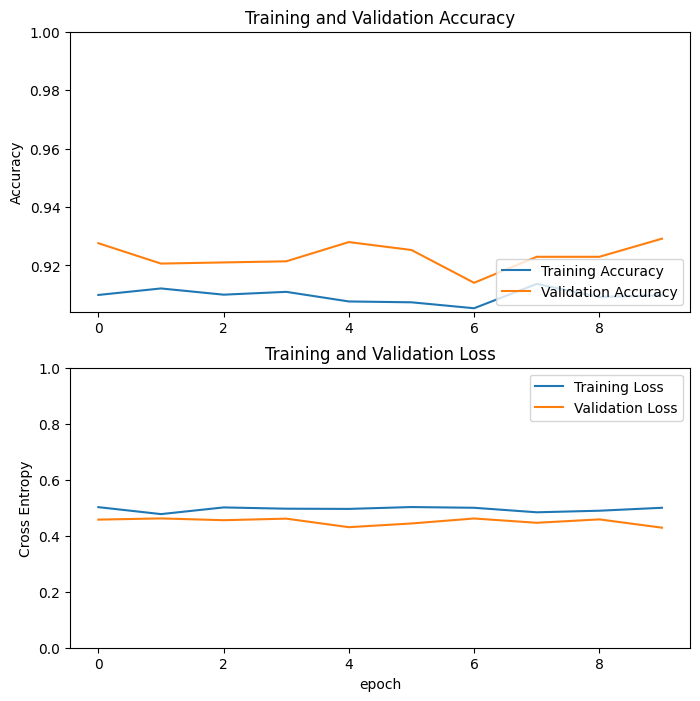

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

base_model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate / 10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = base_model.fit(train_dataset,
                         validation_data=validation_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1])

Epoch 10/20
323/323 [==============================] - 16s 41ms/step - loss: 0.4088 - accuracy: 0.9367 - val_loss: 0.4287 - val_accuracy: 0.9292
Epoch 11/20
323/323 [==============================] - 12s 36ms/step - loss: 0.4067 - accuracy: 0.9364 - val_loss: 0.4287 - val_accuracy: 0.9292
Epoch 12/20
323/323 [==============================] - 11s 35ms/step - loss: 0.4053 - accuracy: 0.9387 - val_loss: 0.4287 - val_accuracy: 0.9292
Epoch 13/20
323/323 [==============================] - 12s 35ms/step - loss: 0.4097 - accuracy: 0.9376 - val_loss: 0.4287 - val_accuracy: 0.9292
Epoch 14/20
323/323 [==============================] - 12s 36ms/step - loss: 0.4056 - accuracy: 0.9390 - val_loss: 0.4287 - val_accuracy: 0.9292
Epoch 15/20
323/323 [==============================] - 14s 42ms/step - loss: 0.4033 - accuracy: 0.9368 - val_loss: 0.4287 - val_accuracy: 0.9292
Epoch 16/20
323/323 [==============================] - 12s 38ms/step - loss: 0.4057 - accuracy: 0.9362 - val_loss: 0.4287 - val_ac

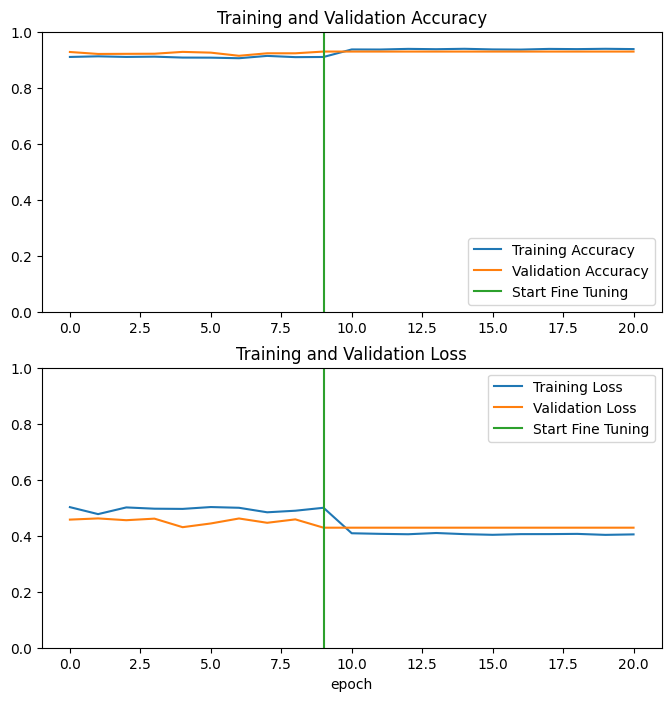

In [69]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()